# Preparazione e costruzione delle serie temporali
**dataset:** /air_quality_health_dataset.csv
si carica e in seguito in questa fase si esplora e si fa un preprocessing dei dati del dataset 
- importo del dataset con riduzione delle colonne per concntrasi solo sulle caratteirtiche piu consone allo studio
- conversione in datetime e ordinamento del dataset
- Aggregazione dei dati con frequenza costante tramite resample (settimanale)

**obiettivo:** ottenere serie regolari, completa e pronta per modelling


In [24]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import matplotlib.dates as mdates
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.stats.diagnostic import acorr_ljungbox
from sklearn.metrics import mean_squared_error, mean_absolute_error
import pmdarima as pm


# Metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Statistical tests
from scipy import stats
from scipy.stats import jarque_bera, shapiro
# Configurazione visualizzazioni
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')
%matplotlib inline

In [25]:
df = pd.read_csv('air_quality_health_dataset.csv')
df_reduced = df[['date', 'region', 'PM2.5', 'NO2', 'O3', 'temperature', 'humidity','wind_speed', 'respiratory_admissions']]
df=df_reduced
df.head()


,date,region,PM2.5,NO2,O3,temperature,humidity,wind_speed,respiratory_admissions
0,2020-01-01,East,31.382887,47.654022,32.574682,37.555663,20.542799,5.204995,11
1,2020-01-02,Central,47.094225,50.734127,23.749138,24.900342,27.308785,6.235446,13
2,2020-01-03,East,53.795917,44.986899,35.530851,23.437165,80.055977,5.673999,3
3,2020-01-04,West,88.315315,20.575023,25.277106,22.388200,25.929988,8.496463,6
4,2020-01-05,South,68.348297,38.445776,35.996440,26.881835,34.946343,1.184104,8


In [26]:
df.tail()

,date,region,PM2.5,NO2,O3,temperature,humidity,wind_speed,respiratory_admissions
2995,2020-03-16,West,62.572040,28.188065,26.473666,30.823665,39.543222,3.582931,8
2996,2020-03-17,Central,77.289722,39.271776,41.684453,28.343987,21.611366,7.660774,7
2997,2020-03-18,East,41.738943,48.380141,39.295269,26.050318,80.183686,10.214574,10
2998,2020-03-19,Central,67.019256,38.993041,31.667658,26.028273,46.396429,6.898789,11
2999,2020-03-20,South,42.445789,30.536862,12.106839,27.691147,43.062449,1.228877,15


non ci sono valori nulli presenti nel datate

In [27]:
# Dataset information
print(f"Dataset shape: {df.shape}\n")
df.info()

Dataset shape: (3000, 9)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 9 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   date                    3000 non-null   object 
 1   region                  3000 non-null   object 
 2   PM2.5                   3000 non-null   float64
 3   NO2                     3000 non-null   float64
 4   O3                      3000 non-null   float64
 5   temperature             3000 non-null   float64
 6   humidity                3000 non-null   float64
 7   wind_speed              3000 non-null   float64
 8   respiratory_admissions  3000 non-null   int64  
dtypes: float64(6), int64(1), object(2)
memory usage: 211.1+ KB


In [28]:
# Numerical feature summary
df.describe()

,PM2.5,NO2,O3,temperature,humidity,wind_speed,respiratory_admissions
count,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000
mean,59.426348,39.789545,29.970248,24.950278,55.064617,7.445412,9.923333
std,15.132393,9.834362,8.026695,4.927167,20.336369,4.296773,3.161031
min,12.349443,0.775997,0.000000,6.724567,20.004725,0.000083,1.000000
25%,49.311574,33.279636,24.590968,21.484840,36.896629,3.705526,8.000000
50%,59.665656,39.771488,29.940792,24.947689,55.411279,7.479178,10.000000
75%,69.579966,46.332485,35.551940,28.309660,72.455010,11.083132,12.000000
max,108.646395,73.777682,61.538648,43.056750,89.978805,14.996841,23.000000


In [29]:
# Check for duplicate rows
df[df.duplicated()]

,date,region,PM2.5,NO2,O3,temperature,humidity,wind_speed,respiratory_admissions


In [30]:
print(df['region'].value_counts())

region
East       635
South      619
North      586
West       583
Central    577
Name: count, dtype: int64


analisi relativa ad un unica regione

In [31]:
df_east = df[df['region'] == 'East']

df_east.head()

,date,region,PM2.5,NO2,O3,temperature,humidity,wind_speed,respiratory_admissions
0,2020-01-01,East,31.382887,47.654022,32.574682,37.555663,20.542799,5.204995,11
2,2020-01-03,East,53.795917,44.986899,35.530851,23.437165,80.055977,5.673999,3
9,2020-01-10,East,52.933130,51.480909,40.945512,35.152729,34.532796,9.904895,11
12,2020-01-13,East,40.692546,14.791530,43.229082,20.291911,23.696398,1.489816,11
26,2020-01-27,East,62.856358,35.634851,32.339874,23.681505,69.055426,8.702339,9


In [32]:
df_east['date'] = pd.to_datetime(df_east['date'])

df_east.set_index('date', inplace=True)
df_east.head()

C:\Users\Asus\AppData\Local\Temp\ipykernel_5812\3526835639.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_east['date'] = pd.to_datetime(df_east['date'])


,region,PM2.5,NO2,O3,temperature,humidity,wind_speed,respiratory_admissions
date,,,,,,,,
2020-01-01,East,31.382887,47.654022,32.574682,37.555663,20.542799,5.204995,11
2020-01-03,East,53.795917,44.986899,35.530851,23.437165,80.055977,5.673999,3
2020-01-10,East,52.933130,51.480909,40.945512,35.152729,34.532796,9.904895,11
2020-01-13,East,40.692546,14.791530,43.229082,20.291911,23.696398,1.489816,11
2020-01-27,East,62.856358,35.634851,32.339874,23.681505,69.055426,8.702339,9


ordinamento del dataset nella colonna date

In [ ]:
df_east = df_east.sort_index()

In [ ]:

# Definiamo come trattare ogni colonna 
aggregation_logic = {
    'PM2.5': 'mean',
    'NO2': 'mean',
    'O3': 'mean',
    'temperature': 'mean',
    'humidity': 'mean',
    'wind_speed': 'mean',
    'respiratory_admissions': 'sum' 
}

# Eseguiamo il resample settimanale
df_weekly = df_east.resample('W').agg(aggregation_logic)

print(df_weekly.head())

Dataset settimanale pronto e allineato:
                PM2.5        NO2         O3  temperature   humidity  \
date                                                                  
2020-01-05  59.384035  36.761954  31.036800    26.866985  52.120856   
2020-01-12  57.604828  44.890266  33.386451    24.287743  52.805481   
2020-01-19  56.847925  33.771576  32.032120    21.802331  40.455749   
2020-01-26  62.029037  43.802169  30.755770    22.198627  57.556851   
2020-02-02  59.843503  35.706730  32.199352    26.193452  50.902530   

            wind_speed  respiratory_admissions  
date                                            
2020-01-05    5.320074                      41  
2020-01-12    9.054286                     125  
2020-01-19    5.082848                      67  
2020-01-26    6.129686                      84  
2020-02-02    6.555219                      88  


In [35]:
df_weekly.isnull().sum()

PM2.5                     0
NO2                       0
O3                        0
temperature               0
humidity                  0
wind_speed                0
respiratory_admissions    0
dtype: int64

# Analisi esplorativa del dataset(EDA)

- analisi standard per vedere i limiti del dataset 
- analisi per mezzo di grafici

calcolare media varianza valori massimi e minimi

In [ ]:
# Creiamo le colonne per Anno e Mese
df_east['year'] = df_east.index.year
df_east['month'] = df_east.index.month

# Definiamo una funzione per mappare i mesi alle stagioni (Inverno, Primavera, Estate, Autunno)
def get_season(month):
    if month in [12, 1, 2]: return 'Winter'
    elif month in [3, 4, 5]: return 'Spring'
    elif month in [6, 7, 8]: return 'Summer'
    else: return 'Autumn'

df_east['season'] = df_east['month'].apply(get_season)

In [ ]:
# Selezioniamo le colonne numeriche di interesse
cols_to_analyze = ['PM2.5', 'NO2', 'O3', 'temperature', 'humidity','wind_speed', 'respiratory_admissions']

print("=== Statistiche descrittive per ANNO (Formato Verticale) ===")

# 1. Calcoliamo le statistiche
yearly_stats = df_east.groupby('year')[cols_to_analyze].agg(['mean', 'var', 'min', 'max'])

yearly_stats_vertical = yearly_stats.stack(level=0).round(2)

print(yearly_stats_vertical)

=== Statistiche descrittive per ANNO (Formato Verticale) ===
                              mean     var    min     max
year                                                     
2020 NO2                     39.80  100.84  10.91   72.88
     O3                      31.04   62.20   5.92   52.58
     PM2.5                   59.19  224.67  16.29  104.03
     humidity                54.63  419.40  20.39   89.89
     respiratory_admissions  10.01    9.37   3.00   19.00
     temperature             25.10   25.17  10.77   37.56
     wind_speed               7.30   18.05   0.01   14.92
2021 NO2                     39.43   89.91   6.24   65.30
     O3                      30.67   70.08   8.62   58.82
     PM2.5                   59.81  242.17  14.89  108.65
     humidity                54.86  421.33  20.32   89.70
     respiratory_admissions   9.76    9.86   3.00   21.00
     temperature             24.79   24.66  13.87   39.99
     wind_speed               7.61   20.54   0.03   14.97


C:\Users\Asus\AppData\Local\Temp\ipykernel_5812\2904462293.py:11: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  yearly_stats_vertical = yearly_stats.stack(level=0).round(2)


In [50]:
print("\n=== Statistiche descrittive per STAGIONE (Formato Verticale) ===")

# 1. Calcoliamo le statistiche come prima
seasonal_stats = df_east.groupby('season')[cols_to_analyze].agg(['mean', 'var', 'min', 'max'])

# 2. Portiamo le variabili a capo (stack) e arrotondiamo per leggibilità
seasonal_stats_vertical = seasonal_stats.stack(level=0).round(2)

# 3. Opzionale: rinominiamo l'indice dello stack per chiarezza
seasonal_stats_vertical.index.names = ['Stagione', 'Variabile']

print(seasonal_stats_vertical)


=== Statistiche descrittive per STAGIONE (Formato Verticale) ===
                                  mean     var    min     max
Stagione Variabile                                           
Autumn   NO2                     40.81   94.06  10.91   72.88
         O3                      30.83   57.40  13.35   58.82
         PM2.5                   59.83  192.00  25.20   92.55
         humidity                53.01  423.40  20.84   89.54
         respiratory_admissions   9.83   10.18   3.00   21.00
         temperature             24.97   23.62  11.65   37.52
         wind_speed               7.36   20.40   0.01   14.95
Spring   NO2                     38.80   98.09  10.27   61.77
         O3                      31.90   57.54   5.92   52.58
         PM2.5                   60.11  250.03  14.89   91.27
         humidity                58.02  410.86  20.32   89.57
         respiratory_admissions   9.85   10.53   3.00   21.00
         temperature             25.47   28.32  13.43   37.83
    

C:\Users\Asus\AppData\Local\Temp\ipykernel_5812\3625588913.py:7: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  seasonal_stats_vertical = seasonal_stats.stack(level=0).round(2)


**Media nel tempo**
I livelli medi di PM2.5 e temperatura risultano complessivamente stabili nel periodo analizzato, senza evidenti trend di lungo periodo. Tuttavia, i ricoveri respiratori mostrano variazioni locali della media, con periodi caratterizzati da valori mediamente più elevati.

**Varianza nel tempo**
L’ampiezza delle fluttuazioni non è uniforme: per il PM2.5 e i ricoveri respiratori si osservano fasi con maggiore dispersione dei valori, alternate a periodi più stabili. Questo suggerisce una varianza non costante nel tempo.

**Stagionalità**
È presente una componente stagionale, più evidente nei ricoveri respiratori, con picchi ricorrenti nei mesi invernali. Le temperature mostrano una stagionalità regolare, mentre il PM2.5 presenta episodi estremi distribuiti lungo l’anno.

**Valori estremi**
Si osservano picchi significativi, in particolare per il PM2.5 e i ricoveri respiratori, che indicano la presenza di eventi episodici potenzialmente rilevanti dal punto di vista sanitario.

In sintesi, le serie temporali non mostrano trend marcati ma presentano variabilità non costante e componenti stagionali, suggerendo una possibile non stazionarietà. Per analisi successive, risulta quindi opportuno valutare tecniche di decomposizione o trasformazione delle serie.


────────────────────────────────────────────────────────────────────────────────
SCATTER PLOTS: PM2.5 vs Ricoveri (Lag 0, 1, 2)
────────────────────────────────────────────────────────────────────────────────



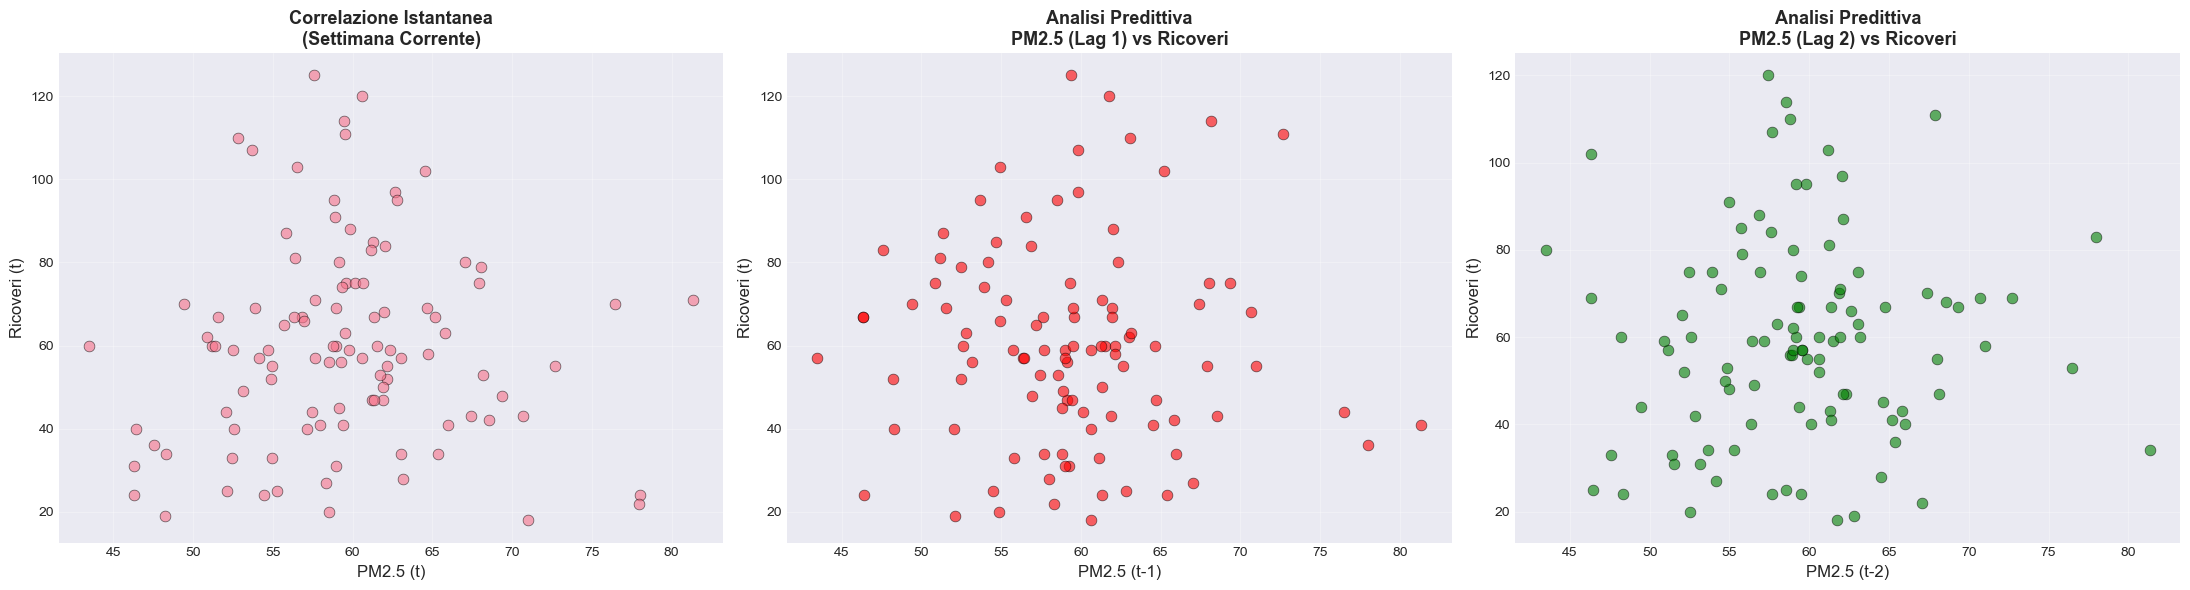

In [ ]:
print("\n" + "─"*80)
print("SCATTER PLOTS: PM2.5 vs Ricoveri (Lag 0, 1, 2)")
print("─"*80 + "\n")

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(22, 6))

# Lag 0
sns.scatterplot(data=df_weekly, x='PM2.5', y='respiratory_admissions', 
                alpha=0.6, ax=ax1, s=60, edgecolor='black', linewidth=0.5)
ax1.set_title('Correlazione Istantanea\n(Settimana Corrente)', fontsize=13, fontweight='bold')
ax1.set_xlabel('PM2.5 (t)', fontsize=12)
ax1.set_ylabel('Ricoveri (t)', fontsize=12)
ax1.grid(True, alpha=0.3)

# Lag 1
sns.scatterplot(x=df_weekly['PM2.5'].shift(1), y=df_weekly['respiratory_admissions'], 
                color='red', alpha=0.6, ax=ax2, s=60, edgecolor='black', linewidth=0.5)
ax2.set_title('Analisi Predittiva\nPM2.5 (Lag 1) vs Ricoveri', fontsize=13, fontweight='bold')
ax2.set_xlabel('PM2.5 (t-1)', fontsize=12)
ax2.set_ylabel('Ricoveri (t)', fontsize=12)
ax2.grid(True, alpha=0.3)

# Lag 2
sns.scatterplot(x=df_weekly['PM2.5'].shift(2), y=df_weekly['respiratory_admissions'], 
                color='green', alpha=0.6, ax=ax3, s=60, edgecolor='black', linewidth=0.5)
ax3.set_title('Analisi Predittiva\nPM2.5 (Lag 2) vs Ricoveri', fontsize=13, fontweight='bold')
ax3.set_xlabel('PM2.5 (t-2)', fontsize=12)
ax3.set_ylabel('Ricoveri (t)', fontsize=12)
ax3.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


L’analisi esplorativa non evidenzia una relazione forte tra PM2.5 e ricoveri respiratori nella stessa settimana. Introducendo ritardi temporali, in particolare a una e due settimane, emerge un segnale più coerente, suggerendo un possibile effetto ritardato e cumulativo dell’esposizione al PM2.5. La distribuzione dei ricoveri è asimmetrica e non normale, mentre l’analisi delle differenze indica che la serie può essere resa stazionaria. Nel complesso, l’effetto del PM2.5 risulta debole e richiede modelli dinamici con lag e controllo della struttura temporale.


────────────────────────────────────────────────────────────────────────────────
DISTRIBUZIONE RICOVERI: Grezzi vs Differenziati
────────────────────────────────────────────────────────────────────────────────



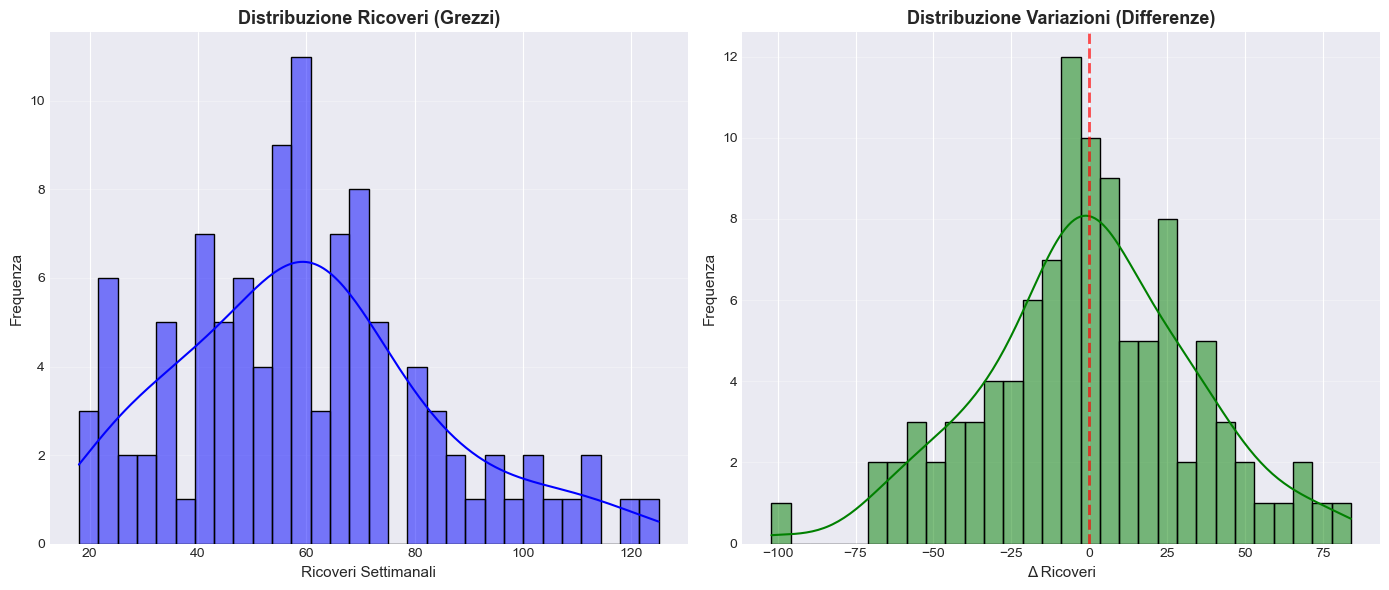

💡 La distribuzione delle differenze è più simmetrica → serie può essere resa stazionaria



In [ ]:
print("\n" + "─"*80)
print("DISTRIBUZIONE RICOVERI: Grezzi vs Differenziati")
print("─"*80 + "\n")

plt.figure(figsize=(14, 6))

# Istogramma grezzi
plt.subplot(1, 2, 1)
sns.histplot(df_weekly['respiratory_admissions'], kde=True, color='blue', bins=30)
plt.title('Distribuzione Ricoveri (Grezzi)', fontsize=13, fontweight='bold')
plt.xlabel('Ricoveri Settimanali', fontsize=11)
plt.ylabel('Frequenza', fontsize=11)
plt.grid(True, alpha=0.3, axis='y')

# Istogramma differenze
plt.subplot(1, 2, 2)
diff_admissions = df_weekly['respiratory_admissions'].diff().dropna()
sns.histplot(diff_admissions, kde=True, color='green', bins=30)
plt.title('Distribuzione Variazioni (Differenze)', fontsize=13, fontweight='bold')
plt.xlabel('Δ Ricoveri', fontsize=11)
plt.ylabel('Frequenza', fontsize=11)
plt.axvline(0, color='red', linestyle='--', linewidth=2, alpha=0.7)
plt.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

print("💡 La distribuzione delle differenze è più simmetrica → serie può essere resa stazionaria\n")


Gli istogrammi mostrano che i ricoveri respiratori non sono normalmente distribuiti in livello, mentre le differenze presentano una distribuzione più simmetrica, indicando che la serie può essere resa stazionaria tramite differenziazione.

────────────────────────────────────────────────────────────────────────────────
VISUALIZZAZIONE SERIE TEMPORALE RICOVERI
────────────────────────────────────────────────────────────────────────────────



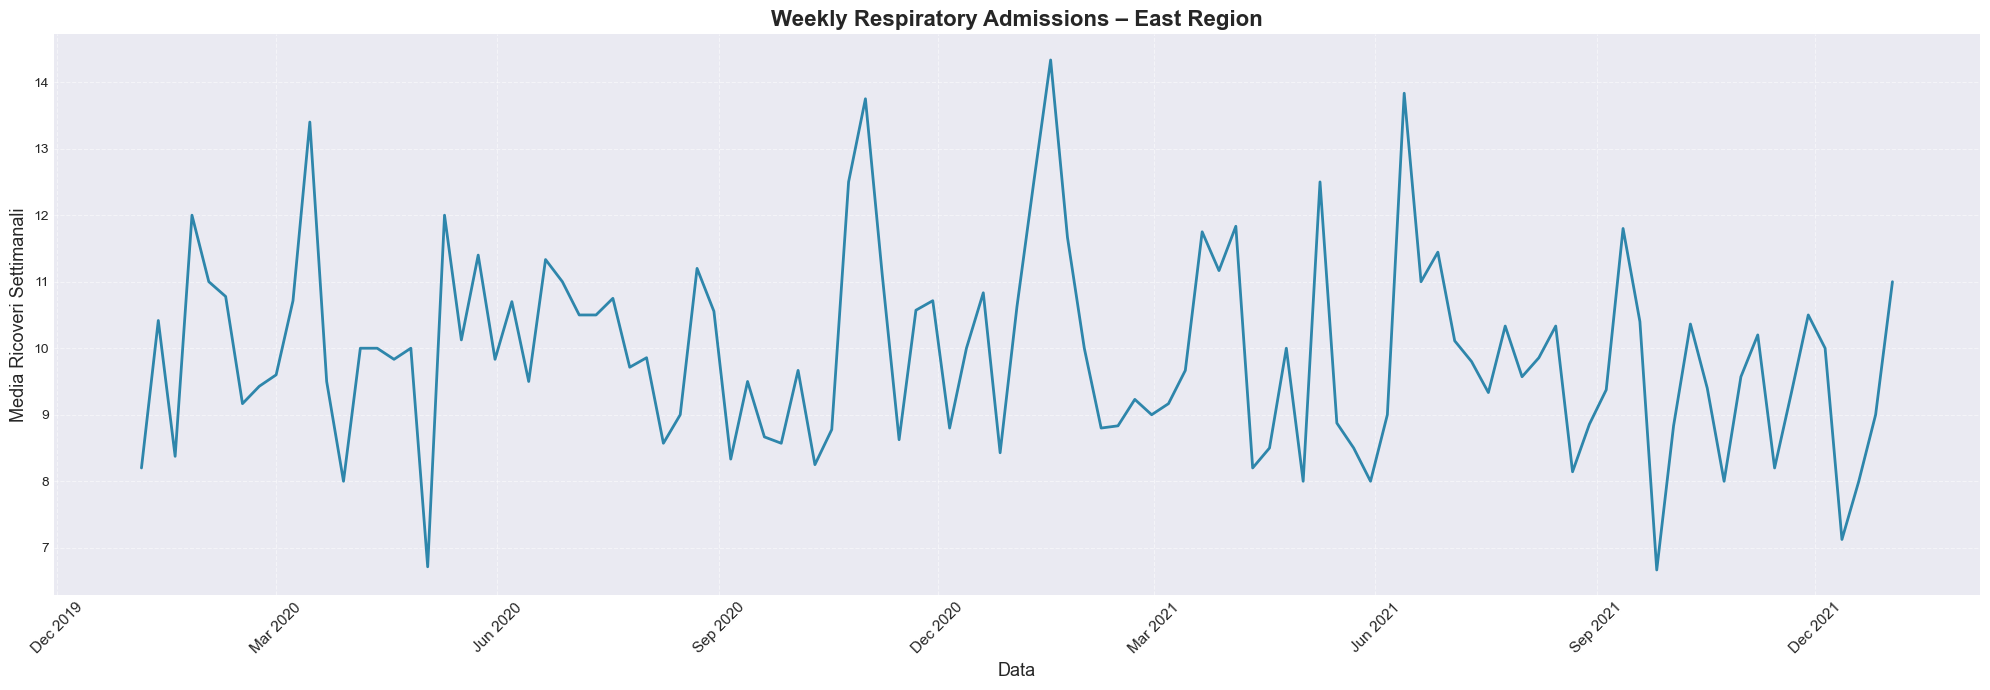

In [ ]:
print("─"*80)
print("VISUALIZZAZIONE SERIE TEMPORALE RICOVERI")
print("─"*80 + "\n")

weekly_resp = df_east['respiratory_admissions'].resample('W').mean()

plt.figure(figsize=(20, 7))
plt.plot(weekly_resp.index, weekly_resp, linewidth=2, color='#2E86AB')

# Formattazione asse X
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=3))
plt.xticks(rotation=45, fontsize=11)

plt.title('Weekly Respiratory Admissions – East Region', fontsize=16, fontweight='bold')
plt.xlabel('Data', fontsize=13)
plt.ylabel('Media Ricoveri Settimanali', fontsize=13)
plt.grid(True, linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

come si puo notare dai grafici l'adamento dei due parametri considerati non sono stazionari
- media non costante nel tempo
- varianza non costante nel tempo
- valori piu contenuti in certi intervalli

## Scomposizione serie temporale
decomposizione stagiaonale per separare: 
- trend di lungo periodo
- stagionalita
- componente residua


FASE 4: DECOMPOSIZIONE STAGIONALE



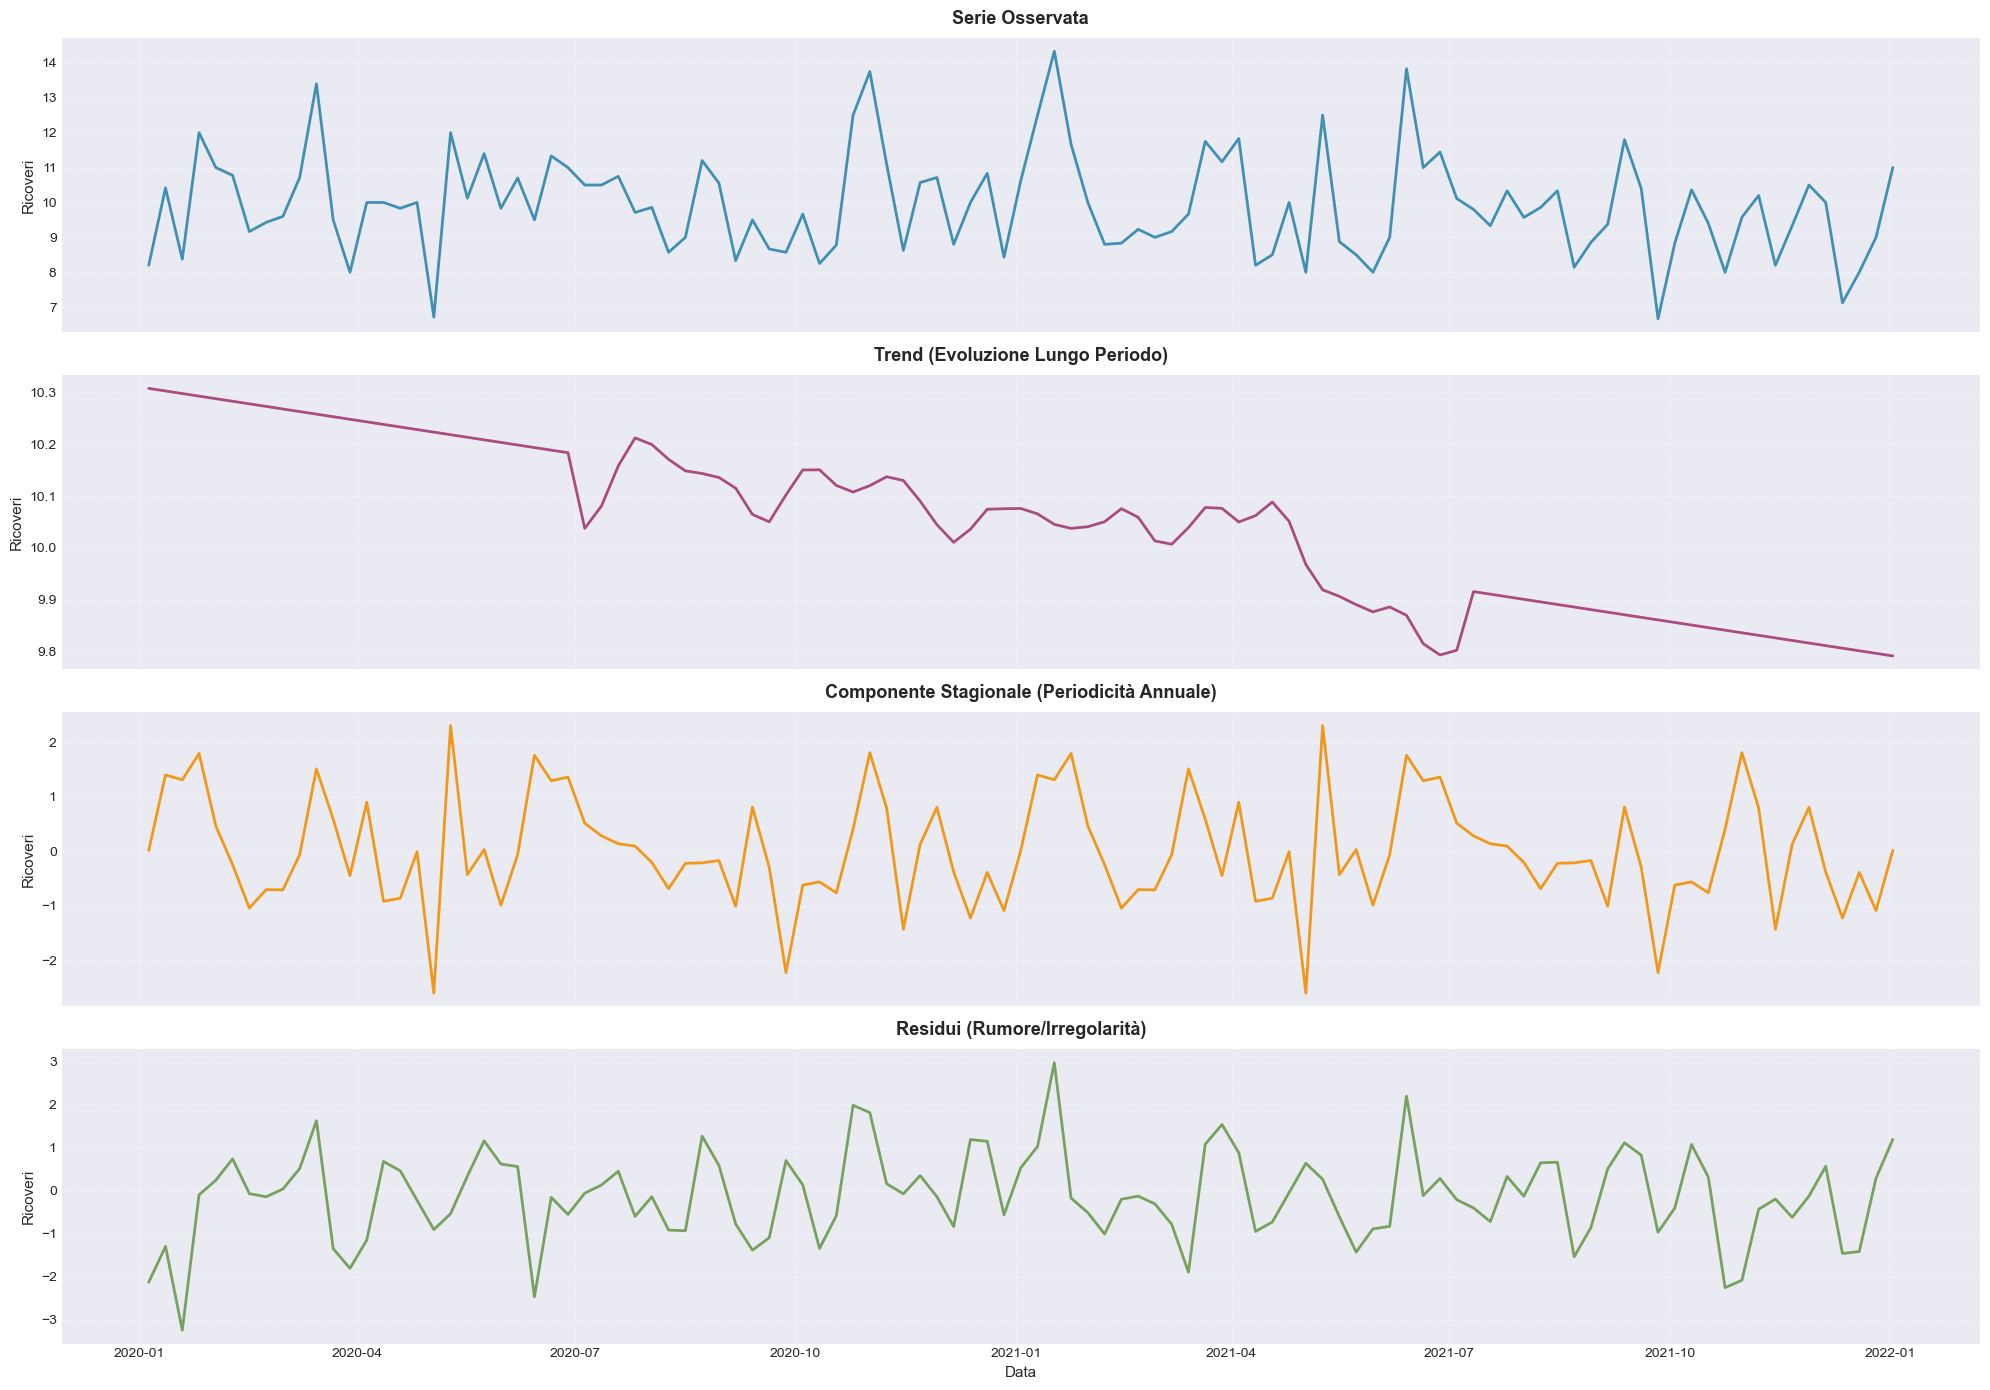

📊 Forza componente stagionale: 0.486 (0=assente, 1=molto forte)



In [ ]:
print("\n" + "="*80)
print("FASE 4: DECOMPOSIZIONE STAGIONALE")
print("="*80 + "\n")

weekly_pm25 = df_east['respiratory_admissions'].resample('W').mean().dropna()

decomposition = seasonal_decompose(
    weekly_pm25, 
    model='additive', 
    period=52,
    extrapolate_trend='freq'
)

fig, axes = plt.subplots(4, 1, figsize=(20, 14), sharex=True)

components = [
    (decomposition.observed, 'Serie Osservata', '#2E86AB'),
    (decomposition.trend, 'Trend (Evoluzione Lungo Periodo)', '#A23B72'),
    (decomposition.seasonal, 'Componente Stagionale (Periodicità Annuale)', '#F18F01'),
    (decomposition.resid, 'Residui (Rumore/Irregolarità)', '#6A994E')
]

for i, (data, title, color) in enumerate(components):
    axes[i].plot(data, color=color, linewidth=2, alpha=0.9)
    axes[i].set_title(title, fontsize=13, fontweight='bold', pad=10)
    axes[i].set_ylabel('Ricoveri', fontsize=11)
    axes[i].grid(True, linestyle='--', alpha=0.4)
    axes[i].spines['top'].set_visible(False)
    axes[i].spines['right'].set_visible(False)

axes[3].set_xlabel('Data', fontsize=11)

plt.tight_layout()
plt.show()

# Forza stagionalità
seasonal_strength = 1 - (decomposition.resid.var() / 
                         (decomposition.seasonal + decomposition.resid).var())
print(f"📊 Forza componente stagionale: {seasonal_strength:.3f} (0=assente, 1=molto forte)\n")


adf-test, per misurare il p-value, che per serie stazionarie dovrebbe essere inferiore a 0,05

FASE 5: TEST DI STAZIONARIETÀ (ADF)


1️⃣  SERIE ORIGINALE

────────────────────────────────────────────────────────────────────────────────
TEST ADF: Ricoveri Respiratori (Originale)
────────────────────────────────────────────────────────────────────────────────
ADF Statistic:        -16.467584
p-value:              0.000000
Lags Used:            1
Observations:         633
Critical Value (1%):  -3.440723
Critical Value (5%):  -2.866117
Critical Value (10%): -2.569207

✓ Serie STAZIONARIA (p-value < 0.05)
  → Rifiutiamo H0: la serie non ha radice unitaria


2️⃣  SERIE DIFFERENZIATA (d=1)

────────────────────────────────────────────────────────────────────────────────
TEST ADF: Ricoveri Respiratori (Differenziata)
────────────────────────────────────────────────────────────────────────────────
ADF Statistic:        -9.714015
p-value:              0.000000
Lags Used:            18
Observations:         615
Critical Value (1%):  -3.441028
Critical Value (5%):  -2.866251
Critical Value 

C:\Users\Asus\AppData\Local\Temp\ipykernel_5812\1976511811.py:92: UserWarning: Glyph 8325 (\N{SUBSCRIPT FIVE}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\Asus\AppData\Local\Temp\ipykernel_5812\1976511811.py:92: UserWarning: Glyph 8322 (\N{SUBSCRIPT TWO}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\Asus\AppData\Local\Temp\ipykernel_5812\1976511811.py:93: UserWarning: Glyph 8325 (\N{SUBSCRIPT FIVE}) missing from font(s) Arial.
  plt.savefig('stationarity_tests.png', dpi=300, bbox_inches='tight')
C:\Users\Asus\AppData\Local\Temp\ipykernel_5812\1976511811.py:93: UserWarning: Glyph 8322 (\N{SUBSCRIPT TWO}) missing from font(s) Arial.
  plt.savefig('stationarity_tests.png', dpi=300, bbox_inches='tight')
c:\Users\Asus\miniconda3\envs\DataScience\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 8325 (\N{SUBSCRIPT FIVE}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\Asus\miniconda3\envs\DataScience\lib\site-packag

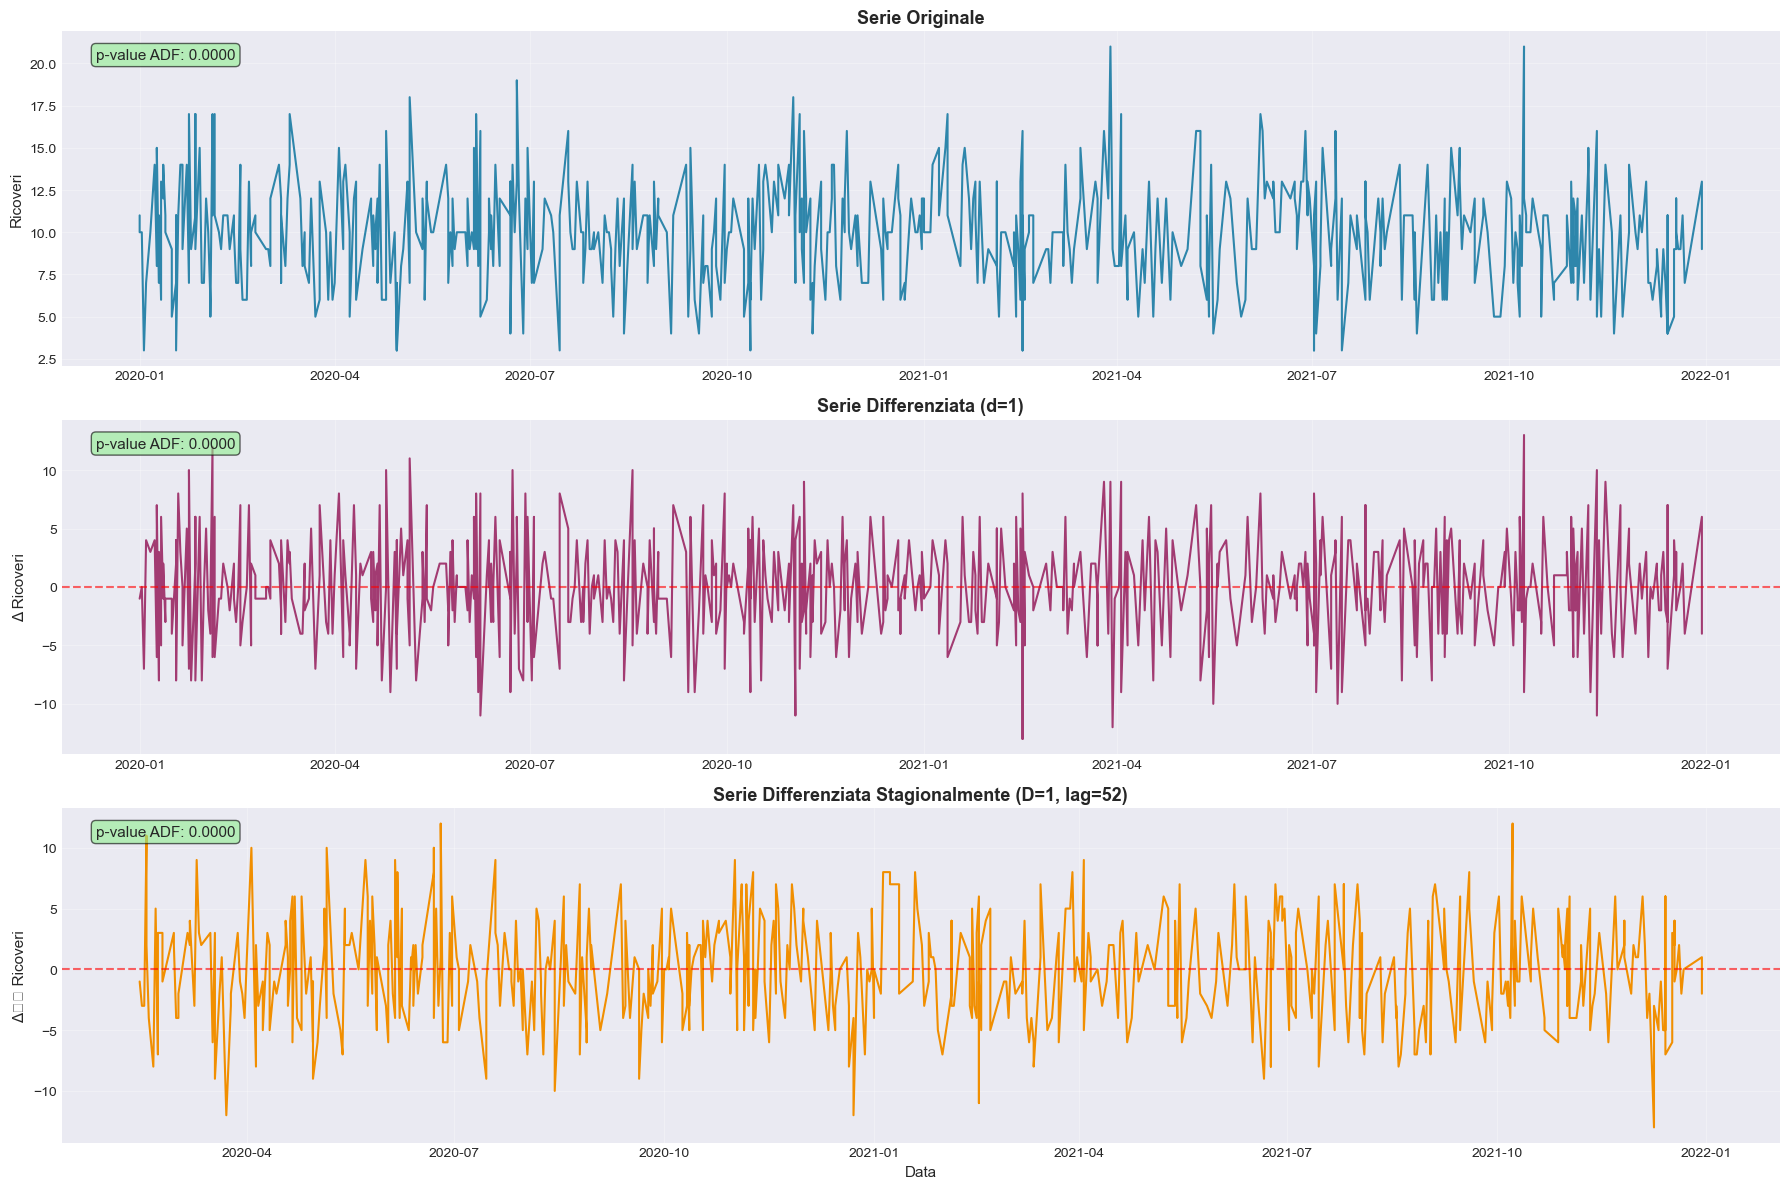

In [ ]:
print("="*80)
print("FASE 5: TEST DI STAZIONARIETÀ (ADF)")
print("="*80 + "\n")

def adf_test_report(series, title):
    """Esegue ADF test e stampa risultati formattati"""
    result = adfuller(series.dropna(), autolag='AIC')
    
    print(f"{'─'*80}")
    print(f"TEST ADF: {title}")
    print(f"{'─'*80}")
    print(f"ADF Statistic:        {result[0]:.6f}")
    print(f"p-value:              {result[1]:.6f}")
    print(f"Lags Used:            {result[2]}")
    print(f"Observations:         {result[3]}")
    print(f"Critical Value (1%):  {result[4]['1%']:.6f}")
    print(f"Critical Value (5%):  {result[4]['5%']:.6f}")
    print(f"Critical Value (10%): {result[4]['10%']:.6f}")
    
    if result[1] < 0.05:
        print(f"\n✓ Serie STAZIONARIA (p-value < 0.05)")
        print(f"  → Rifiutiamo H0: la serie non ha radice unitaria")
    else:
        print(f"\n✗ Serie NON STAZIONARIA (p-value >= 0.05)")
        print(f"  → Non possiamo rifiutare H0: probabile radice unitaria")
        print(f"  → Necessaria differenziazione")
    print()
    
    return result

# Test serie originale
print("\n1️⃣  SERIE ORIGINALE\n")
adf_original = adf_test_report(df_east['respiratory_admissions'], 
                                'Ricoveri Respiratori (Originale)')

# MIGLIORAMENTO: Test serie differenziata
print("\n2️⃣  SERIE DIFFERENZIATA (d=1)\n")
diff_series = df_east['respiratory_admissions'].diff().dropna()
adf_diff = adf_test_report(diff_series, 
                           'Ricoveri Respiratori (Differenziata)')

# MIGLIORAMENTO: Test diff stagionale
print("\n3️⃣  SERIE DIFFERENZIATA STAGIONALMENTE (D=1, lag=52)\n")
seasonal_diff = df_east['respiratory_admissions'].diff(52).dropna()
adf_seasonal = adf_test_report(seasonal_diff, 
                               'Ricoveri Respiratori (Diff. Stagionale)')

# Visualizzazione comparativa
fig, axes = plt.subplots(3, 1, figsize=(18, 12))

# Serie originale
axes[0].plot(df_east.index, df_east['respiratory_admissions'], 
            linewidth=1.5, color='#2E86AB')
axes[0].set_title('Serie Originale', fontsize=13, fontweight='bold')
axes[0].set_ylabel('Ricoveri', fontsize=11)
axes[0].grid(True, alpha=0.3)
axes[0].text(0.02, 0.95, f"p-value ADF: {adf_original[1]:.4f}", 
            transform=axes[0].transAxes, fontsize=11,
            verticalalignment='top', 
            bbox=dict(boxstyle='round', 
                     facecolor='yellow' if adf_original[1] >= 0.05 else 'lightgreen', 
                     alpha=0.6))

# Serie differenziata
axes[1].plot(diff_series.index, diff_series, linewidth=1.5, color='#A23B72')
axes[1].axhline(0, color='red', linestyle='--', alpha=0.6)
axes[1].set_title('Serie Differenziata (d=1)', fontsize=13, fontweight='bold')
axes[1].set_ylabel('Δ Ricoveri', fontsize=11)
axes[1].grid(True, alpha=0.3)
axes[1].text(0.02, 0.95, f"p-value ADF: {adf_diff[1]:.4f}", 
            transform=axes[1].transAxes, fontsize=11,
            verticalalignment='top', 
            bbox=dict(boxstyle='round', 
                     facecolor='yellow' if adf_diff[1] >= 0.05 else 'lightgreen', 
                     alpha=0.6))

# Diff stagionale
axes[2].plot(seasonal_diff.index, seasonal_diff, linewidth=1.5, color='#F18F01')
axes[2].axhline(0, color='red', linestyle='--', alpha=0.6)
axes[2].set_title('Serie Differenziata Stagionalmente (D=1, lag=52)', 
                 fontsize=13, fontweight='bold')
axes[2].set_ylabel('Δ₅₂ Ricoveri', fontsize=11)
axes[2].set_xlabel('Data', fontsize=11)
axes[2].grid(True, alpha=0.3)
axes[2].text(0.02, 0.95, f"p-value ADF: {adf_seasonal[1]:.4f}", 
            transform=axes[2].transAxes, fontsize=11,
            verticalalignment='top', 
            bbox=dict(boxstyle='round', 
                     facecolor='yellow' if adf_seasonal[1] >= 0.05 else 'lightgreen', 
                     alpha=0.6))

plt.tight_layout()
plt.show()

## Analisi dei correlogrammi  
- acf
- pacf


FASE 6: ANALISI ACF/PACF



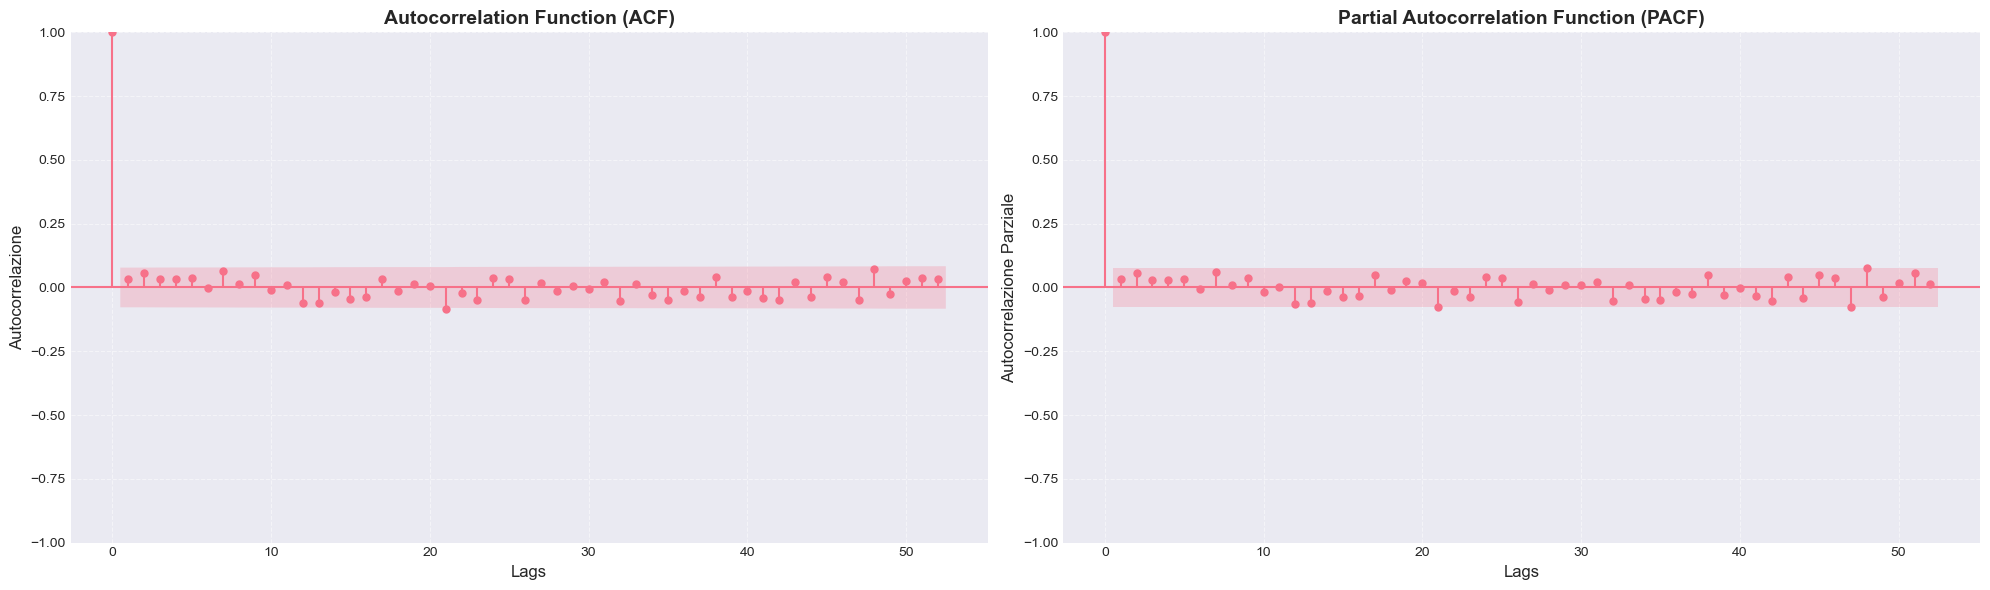

💡 INTERPRETAZIONE:
   • ACF decay lento → presenza di trend/non-stazionarietà
   • PACF con picchi significativi → componente AR
   • Picchi multipli di 52 → forte stagionalità annuale



In [ ]:
print("\n" + "="*80)
print("FASE 6: ANALISI ACF/PACF")
print("="*80 + "\n")

fig, axes = plt.subplots(1, 2, figsize=(20, 6), dpi=100)

# ACF
plot_acf(df_east['respiratory_admissions'], lags=52, ax=axes[0])
axes[0].set_title('Autocorrelation Function (ACF)', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Lags', fontsize=12)
axes[0].set_ylabel('Autocorrelazione', fontsize=12)
axes[0].grid(True, linestyle='--', alpha=0.5)

# PACF
plot_pacf(df_east['respiratory_admissions'], lags=52, ax=axes[1])
axes[1].set_title('Partial Autocorrelation Function (PACF)', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Lags', fontsize=12)
axes[1].set_ylabel('Autocorrelazione Parziale', fontsize=12)
axes[1].grid(True, linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

print("💡 INTERPRETAZIONE:")
print("   • ACF decay lento → presenza di trend/non-stazionarietà")
print("   • PACF con picchi significativi → componente AR")
print("   • Picchi multipli di 52 → forte stagionalità annuale\n")

In [45]:
print("="*80)
print("FASE 7: RICERCA PARAMETRI OTTIMALI (AUTO_ARIMA)")
print("="*80 + "\n")

print("🔍 Ricerca in corso (può richiedere 2-3 minuti)...\n")

sarima_model = pm.auto_arima(
    df_east['respiratory_admissions'],
    seasonal=True,
    m=52,
    d=1,  # Differenziazione semplice
    D=1,  # Differenziazione stagionale
    start_p=0, start_q=0,
    start_P=0, start_Q=0,
    max_p=2, max_q=2,
    max_P=2, max_Q=2,
    trace=True,
    error_action='ignore',
    suppress_warnings=True,
    stepwise=True,
    information_criterion='aic'
)

print("\n" + "─"*80)
print("MODELLO OTTIMALE TROVATO")
print("─"*80 + "\n")
print(sarima_model.summary())

best_order = sarima_model.order
best_seasonal = sarima_model.seasonal_order

print(f"\n✓ Parametri ottimali: SARIMA{best_order} × {best_seasonal}\n")



FASE 7: RICERCA PARAMETRI OTTIMALI (AUTO_ARIMA)

🔍 Ricerca in corso (può richiedere 2-3 minuti)...

Performing stepwise search to minimize aic


c:\Users\Asus\miniconda3\envs\DataScience\lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\Asus\miniconda3\envs\DataScience\lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,0)(0,1,0)[52]             : AIC=3727.326, Time=0.19 sec


c:\Users\Asus\miniconda3\envs\DataScience\lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,0)(1,1,0)[52]             : AIC=3432.271, Time=1.62 sec


c:\Users\Asus\miniconda3\envs\DataScience\lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,1)(0,1,1)[52]             : AIC=inf, Time=8.80 sec


c:\Users\Asus\miniconda3\envs\DataScience\lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,0)(0,1,0)[52]             : AIC=3574.785, Time=0.55 sec


c:\Users\Asus\miniconda3\envs\DataScience\lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,0)(2,1,0)[52]             : AIC=inf, Time=7.27 sec


c:\Users\Asus\miniconda3\envs\DataScience\lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,0)(1,1,1)[52]             : AIC=inf, Time=21.24 sec


c:\Users\Asus\miniconda3\envs\DataScience\lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,0)(0,1,1)[52]             : AIC=inf, Time=14.21 sec


c:\Users\Asus\miniconda3\envs\DataScience\lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,0)(2,1,1)[52]             : AIC=inf, Time=32.04 sec


c:\Users\Asus\miniconda3\envs\DataScience\lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,0)(1,1,0)[52]             : AIC=3594.443, Time=1.78 sec


c:\Users\Asus\miniconda3\envs\DataScience\lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,0)(1,1,0)[52]             : AIC=3376.049, Time=3.38 sec


c:\Users\Asus\miniconda3\envs\DataScience\lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,0)(0,1,0)[52]             : AIC=3505.636, Time=0.73 sec


c:\Users\Asus\miniconda3\envs\DataScience\lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,0)(2,1,0)[52]             : AIC=inf, Time=8.57 sec


c:\Users\Asus\miniconda3\envs\DataScience\lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,0)(1,1,1)[52]             : AIC=inf, Time=27.54 sec


c:\Users\Asus\miniconda3\envs\DataScience\lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,0)(0,1,1)[52]             : AIC=inf, Time=11.86 sec


c:\Users\Asus\miniconda3\envs\DataScience\lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,0)(2,1,1)[52]             : AIC=inf, Time=30.19 sec


c:\Users\Asus\miniconda3\envs\DataScience\lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,1)(1,1,0)[52]             : AIC=inf, Time=32.44 sec


c:\Users\Asus\miniconda3\envs\DataScience\lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,1)(1,1,0)[52]             : AIC=inf, Time=22.57 sec


c:\Users\Asus\miniconda3\envs\DataScience\lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,0)(1,1,0)[52] intercept   : AIC=3378.048, Time=8.01 sec

Best model:  ARIMA(2,1,0)(1,1,0)[52]          
Total fit time: 233.039 seconds

────────────────────────────────────────────────────────────────────────────────
MODELLO OTTIMALE TROVATO
────────────────────────────────────────────────────────────────────────────────

                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                  635
Model:             SARIMAX(2, 1, 0)x(1, 1, 0, 52)   Log Likelihood               -1684.025
Date:                            Thu, 12 Feb 2026   AIC                           3376.049
Time:                                    12:48:57   BIC                           3393.515
Sample:                                         0   HQIC                          3382.858
                                            - 635                                         
Covariance Type:           

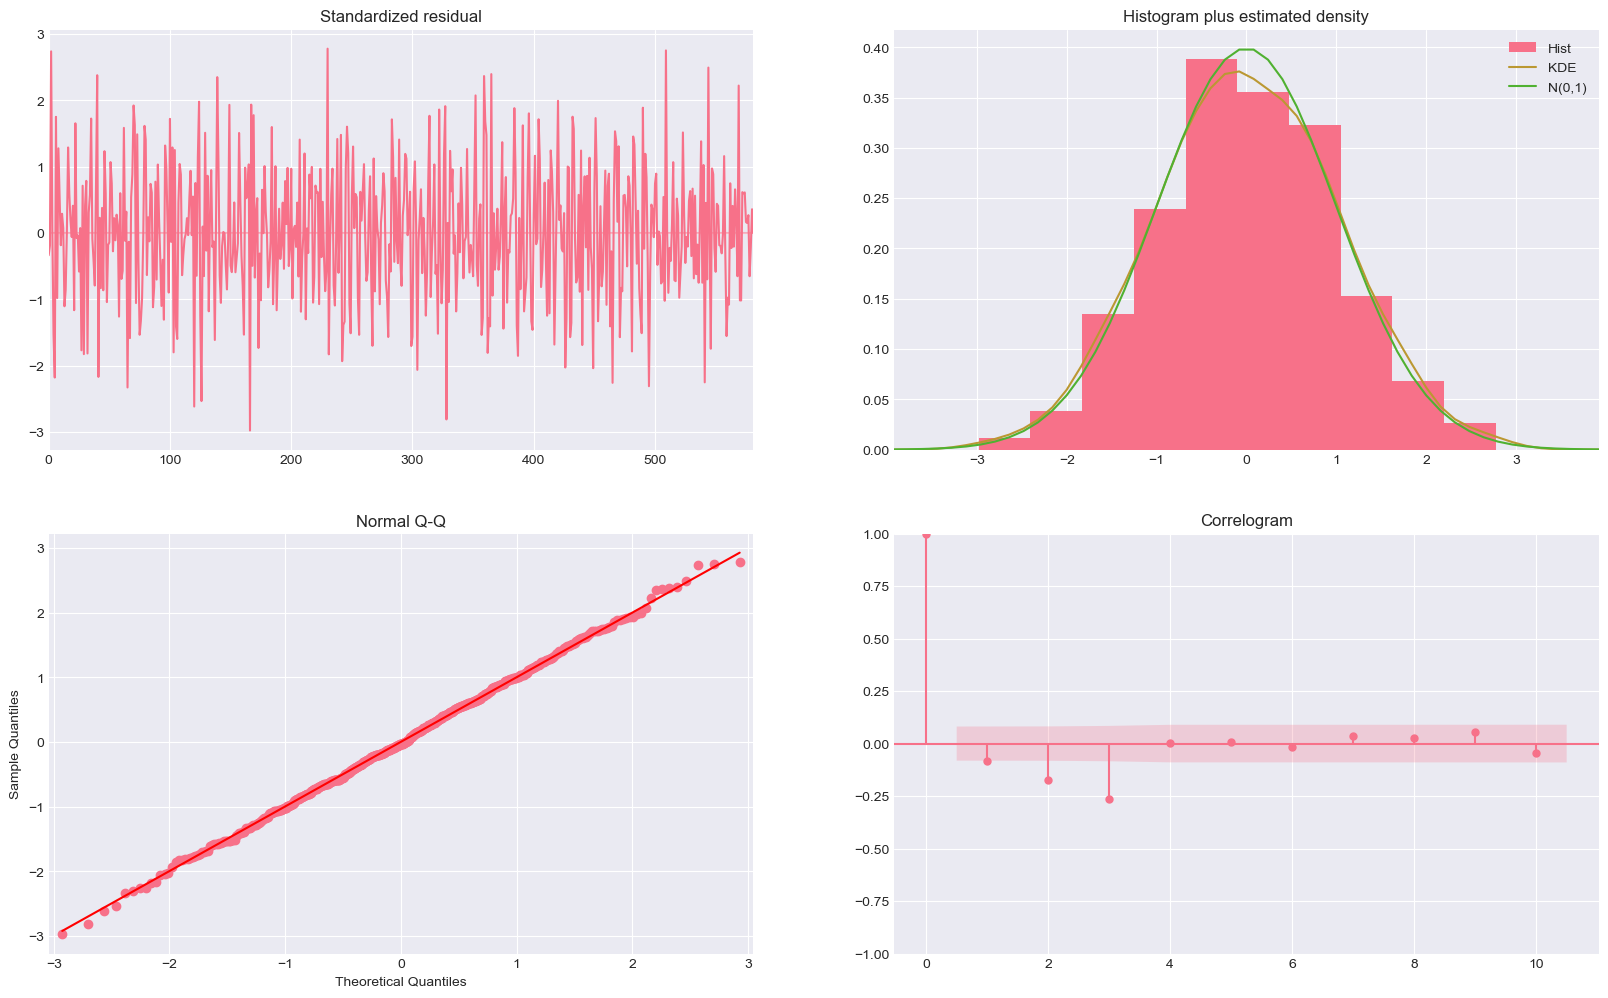

In [46]:
# Diagnostica del modello SARIMA
sarima_model.plot_diagnostics(figsize=(20, 12));

# Addestramento modello

In [47]:
print("="*80)
print("FASE 8: TRAIN/TEST SPLIT")
print("="*80 + "\n")

train_size = int(len(df_east) * 0.8)
train = df_east[:train_size]
test = df_east[train_size:]

print(f"📊 Training set:  {train.index[0]} → {train.index[-1]} ({len(train)} giorni)")
print(f"📊 Test set:      {test.index[0]} → {test.index[-1]} ({len(test)} giorni)")
print(f"   Split:         {len(train)/len(df_east)*100:.1f}% / {len(test)/len(df_east)*100:.1f}%\n")


FASE 8: TRAIN/TEST SPLIT

📊 Training set:  2020-01-01 00:00:00 → 2021-08-02 00:00:00 (508 giorni)
📊 Test set:      2021-08-03 00:00:00 → 2021-12-30 00:00:00 (127 giorni)
   Split:         80.0% / 20.0%



In [ ]:
print("="*80)
print("MODELLO 1: SARIMA UNIVARIATO (Solo Serie Storica Ricoveri)")
print("="*80 + "\n")

# CORREZIONE: Usa parametri da auto_arima invece di (2,0,0)x(2,0,0,52)
print(f"🚀 Training SARIMA{best_order}x{best_seasonal}...\n")

model_sarima = SARIMAX(
    train['respiratory_admissions'], 
    order=best_order,
    seasonal_order=best_seasonal,
    trend='c'
)

model_fit_sarima = model_sarima.fit(disp=False, maxiter=200)

print("✓ Modello SARIMA addestrato\n")
print(model_fit_sarima.summary())

# Previsioni
forecast_sarima = model_fit_sarima.get_forecast(steps=len(test))
forecast_mean_sarima = forecast_sarima.predicted_mean
forecast_ci_sarima = forecast_sarima.conf_int()

# Metriche
mae_sarima = mean_absolute_error(test['respiratory_admissions'], forecast_mean_sarima)
rmse_sarima = np.sqrt(mean_squared_error(test['respiratory_admissions'], forecast_mean_sarima))
mape_sarima = np.mean(np.abs((test['respiratory_admissions'] - forecast_mean_sarima) / 
                              test['respiratory_admissions'])) * 100
r2_sarima = r2_score(test['respiratory_admissions'], forecast_mean_sarima)

print(f"\n📊 PERFORMANCE SARIMA (Test Set):\n")
print(f"   MAE:   {mae_sarima:.2f} ricoveri")
print(f"   RMSE:  {rmse_sarima:.2f} ricoveri")
print(f"   MAPE:  {mape_sarima:.2f}%")
print(f"   R²:    {r2_sarima:.4f}\n")

# Visualizzazione
plt.figure(figsize=(18, 7))
plt.plot(train.index, train['respiratory_admissions'], 
        label='Training Data', color='#2E86AB', linewidth=2)
plt.plot(test.index, test['respiratory_admissions'], 
        label='Test Data (Actual)', color='black', linewidth=2)
plt.plot(test.index, forecast_mean_sarima, 
        label='SARIMA Forecast', color='#E63946', linewidth=2, linestyle='--')
plt.fill_between(test.index, 
                forecast_ci_sarima.iloc[:, 0], 
                forecast_ci_sarima.iloc[:, 1],
                label='95% Confidence Interval', color='grey', alpha=0.2)

plt.axvline(test.index[0], color='red', linestyle=':', linewidth=2, alpha=0.7)
plt.text(test.index[0], plt.ylim()[1]*0.95, 'Train/Test Split', 
        rotation=90, verticalalignment='top', fontsize=11, color='red')

plt.title(f'SARIMA{best_order}×{best_seasonal} - Previsione Ricoveri', 
         fontsize=14, fontweight='bold')
plt.xlabel('Data', fontsize=12)
plt.ylabel('Ricoveri', fontsize=12)
plt.legend(fontsize=11, loc='upper left')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


MODELLO 1: SARIMA UNIVARIATO (Solo Serie Storica Ricoveri)

🚀 Training SARIMA(2, 1, 0)x(1, 1, 0, 52)...



c:\Users\Asus\miniconda3\envs\DataScience\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Asus\miniconda3\envs\DataScience\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


✓ Modello SARIMA addestrato

                                     SARIMAX Results                                      
Dep. Variable:             respiratory_admissions   No. Observations:                  508
Model:             SARIMAX(2, 1, 0)x(1, 1, 0, 52)   Log Likelihood               -1327.245
Date:                            Thu, 12 Feb 2026   AIC                           2664.490
Time:                                    12:49:06   BIC                           2685.092
Sample:                                         0   HQIC                          2672.606
                                            - 508                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.0001      0.217     -0.001      1.000      -0.425       0.425
ar.L1 

c:\Users\Asus\miniconda3\envs\DataScience\lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\Asus\miniconda3\envs\DataScience\lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


ValueError: Length of values (338) does not match length of index (254)

In [ ]:
print("\n" + "="*80)
print("DIAGNOSTICA RESIDUI - SARIMA")
print("="*80 + "\n")

residuals = model_fit_sarima.resid

# Test normalità
jb_stat, jb_pvalue = jarque_bera(residuals)
shapiro_stat, shapiro_pvalue = shapiro(residuals)

print("📊 TEST DI NORMALITÀ:\n")
print(f"   Jarque-Bera:")
print(f"      Statistic: {jb_stat:.4f}")
print(f"      p-value:   {jb_pvalue:.4f}")
print(f"      → {'✓ Residui normali (p>0.05)' if jb_pvalue > 0.05 else '✗ Residui non normali (p<0.05)'}\n")

print(f"   Shapiro-Wilk:")
print(f"      Statistic: {shapiro_stat:.4f}")
print(f"      p-value:   {shapiro_pvalue:.4f}")
print(f"      → {'✓ Residui normali (p>0.05)' if shapiro_pvalue > 0.05 else '✗ Residui non normali (p<0.05)'}\n")

# Test Ljung-Box autocorrelazione
lb_test = acorr_ljungbox(residuals, lags=20, return_df=True)
print("📊 LJUNG-BOX TEST (Autocorrelazione):\n")
print(lb_test.head(10))
autocorr_ok = (lb_test['lb_pvalue'] > 0.05).sum() / len(lb_test) > 0.9
print(f"\n   → {'✓ Nessuna autocorrelazione significativa' if autocorr_ok else '⚠️ Autocorrelazione presente'}\n")

# Visualizzazione diagnostica
sarima_model.plot_diagnostics(figsize=(20, 12))
plt.savefig('sarima_diagnostics.png', dpi=300, bbox_inches='tight')
plt.show()


DIAGNOSTICA RESIDUI - SARIMA



NameError: name 'model_fit_sarima' is not defined

In [ ]:
print("\n" + "="*80)
print("MODELLO 2: SARIMAX MULTIVARIATO (CON VARIABILI ESOGENE)")
print("="*80 + "\n")

# Variabili esogene
exog_vars = ['PM2.5', 'NO2', 'O3', 'temperature', 'humidity']
print(f"🔧 Variabili esogene: {exog_vars}\n")

# Train/test con esogene
X_train = train[exog_vars]
X_test = test[exog_vars]
y_train = train['respiratory_admissions']
y_test = test['respiratory_admissions']

print(f"🚀 Training SARIMAX{best_order}×{best_seasonal} con esogene...\n")

model_sarimax = SARIMAX(
    y_train,
    exog=X_train,
    order=best_order,
    seasonal_order=best_seasonal,
    trend='c'
)

model_fit_sarimax = model_sarimax.fit(disp=False, maxiter=200)

print("✓ Modello SARIMAX addestrato\n")
print(model_fit_sarimax.summary())

# Previsioni
forecast_sarimax = model_fit_sarimax.get_forecast(steps=len(test), exog=X_test)
forecast_mean_sarimax = forecast_sarimax.predicted_mean
forecast_ci_sarimax = forecast_sarimax.conf_int()

# Metriche
mae_sarimax = mean_absolute_error(y_test, forecast_mean_sarimax)
rmse_sarimax = np.sqrt(mean_squared_error(y_test, forecast_mean_sarimax))
mape_sarimax = np.mean(np.abs((y_test - forecast_mean_sarimax) / y_test)) * 100
r2_sarimax = r2_score(y_test, forecast_mean_sarimax)

print(f"\n📊 PERFORMANCE SARIMAX (Test Set):\n")
print(f"   MAE:   {mae_sarimax:.2f} ricoveri")
print(f"   RMSE:  {rmse_sarimax:.2f} ricoveri")
print(f"   MAPE:  {mape_sarimax:.2f}%")
print(f"   R²:    {r2_sarimax:.4f}\n")

print(f"📈 MIGLIORAMENTO vs SARIMA:\n")
print(f"   ΔMAE:   {((mae_sarimax - mae_sarima) / mae_sarima * 100):+.2f}%")
print(f"   ΔRMSE:  {((rmse_sarimax - rmse_sarima) / rmse_sarima * 100):+.2f}%")
print(f"   ΔMAPE:  {((mape_sarimax - mape_sarima) / mape_sarima * 100):+.2f}%")
print(f"   ΔR²:    {(r2_sarimax - r2_sarima):+.4f}\n")


MODELLO 2: SARIMAX MULTIVARIATO (CON VARIABILI ESOGENE)

🔧 Variabili esogene: ['PM2.5', 'NO2', 'O3', 'temperature', 'humidity']

🚀 Training SARIMAX(2, 1, 0)×(1, 1, 0, 52) con esogene...

✓ Modello SARIMAX addestrato

                                     SARIMAX Results                                      
Dep. Variable:             respiratory_admissions   No. Observations:                  508
Model:             SARIMAX(2, 1, 0)x(1, 1, 0, 52)   Log Likelihood               -1322.444
Date:                            Tue, 10 Feb 2026   AIC                           2664.888
Time:                                    16:25:54   BIC                           2706.091
Sample:                                         0   HQIC                          2681.120
                                            - 508                                         
Covariance Type:                              opg                                         
                  coef    std err          z      P>|z

ValueError: Length of values (338) does not match length of index (254)